A notebook which contains an evaluation of the SalishSeaCast model within PugetSound for the year 2019. This evaluation includes scatter plots and 2d histograms visualizing the similarity of observed and model data as well as tables evaluation statistics. The observed data compared to the model data in this evaluation was collected using CTD

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
year=2009
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [3]:
display(Markdown('''## Year: '''+ str(year)))

## Year: 2009

In [4]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of chlorophyll, temperature and salinity between 201905 runs and CTD observations

In [5]:
##### Loading in pickle file data
saveloc='/ocean/kflanaga/MEOPAR/savedData'
with open(os.path.join(saveloc,f'data_CTD_{modelversion}_{year}.pkl'),'rb') as hh:
    data_CTD=pickle.load(hh)

In [6]:
def byDepth(data,ax,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(data,datreg,ax,obsvar,modvar,lims):
    ps=[]
    for ind, iregion in enumerate(data.Basin.unique()):
        ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                color = colors[ind], label=iregion)
        ps0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                        cols=(colors[ind],),lname=iregion)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byStation(data,datstat,ax,obsvar,modvar,lims,region):
    ps=[]
    for ind, istation in enumerate(data[data['Basin'] == region].Station.unique()):
        ax.plot(datstat[istation]['Lon'], datstat[istation]['Lat'],'.',
                    color = colors[ind], label=istation)
        ps0=et.varvarPlot(ax,datstat[istation],obsvar,modvar,
                        cols=(colors[ind],),lname=istation)
        ps.append(ps0)
    l=ax.legend(title='Stations',title_fontsize=20,handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def hist2d(data,ax,obsvar,modvar,lims,fontsize=12):
    ax.plot((-250,250),(-250,250),'k-',alpha=.2)
    ii=(~np.isnan(data[obsvar]))&(~np.isnan(data[modvar]))
    counts, xedges, yedges, ps=ax.hist2d(data.loc[ii,[obsvar]].values.flatten(),
                                      data.loc[ii,[modvar]].values.flatten(),bins=25*3,norm=LogNorm())
    cb=fig.colorbar(ps,ax=ax,label='Count',shrink=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_ylabel('Modeled',fontsize=fontsize)
    ax.set_xlabel('Observed',fontsize=fontsize)
    plt.tight_layout()
    return ps

def bySeason_hist2d(seaons,ax,obsvar,modvar,lims):
    for axj in ax:
        for axi in axj:
            axi.plot(lims,lims,'k-')
            axi.set_xlim(lims)
            axi.set_ylim(lims)
            axi.set_aspect(1)
            axi.set_xlabel('Obs')
            axi.set_ylabel('Model')
    jp=hist2d(seaons[0],ax[0][0],obsvar,modvar,lims)
    ax[0][0].set_title('Jan-Mar')
    jp=hist2d(seaons[1],ax[0][1],obsvar,modvar,lims)
    ax[0][1].set_title('Apr')
    jp=hist2d(seaons[2],ax[1][0],obsvar,modvar,lims)
    ax[1][0].set_title('May-Aug')
    jp=hist2d(seasons[3],ax[1][1],obsvar,modvar,lims)
    ax[1][1].set_title('Sep-Dec')
    return 

def bySeason(seaons,ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],seaons[0],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],seaons[1],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],seaons[2],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],seasons[3],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

In [7]:
def multi_station_graph(data,datstat,figrange,obsvar,modvar,regions,down=6,figsize=(14,40)):
    ''' A function that creates a series of scatter plots and maps for each region
    
    :arg figrange: A pair of values that will decide the range of the graph. Should always
                    should always be larger than the maximum value of the variable.
    :type : tuple
                    
    :arg obsvar,modvar: The name of the observed and model variables you wish to compare to each other.
    :type :string
    
    :are regions: The names of all of the basins you wish to look at 
    :type : list of strings
    
    :arg down: A number which should be equal to the number of regions you are looking at
    :type : integer
    
    :arg figsize: a pair of values that decide the size of the entire figure
    '''
    fig, ax = plt.subplots(down,2,figsize = figsize)
    for d,r in zip(range(down),regions):
        ps=byStation(data,datstat,ax[d][0],obsvar,modvar,figrange,r)
        ax[d][0].set_title(f'{obsvar} ($\mu$M) in {r} by Station');

        with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
            viz_tools.plot_coastline(ax[d][1], grid, coords = 'map',isobath=.1)

        for ind, istation in enumerate(data[data['Basin'] == r].Station.unique()):
            ax[d][1].plot(datstat[istation]['Lon'], datstat[istation]['Lat'],'.',
                color = colors[ind], label=istation)
        ax[d][1].set_ylim(47, 49)
        ax[d][1].legend(bbox_to_anchor=[1,.6,0,0])
        ax[d][1].set_xlim(-124, -122);
        ax[d][1].set_title(f'Observation Locations for {r}');

def logt(x):
    return np.log10(x+.001)

In [8]:
#Adding extra columns to assist in analysis.
data_CTD['log_Chl']=logt(data_CTD['Chl'])
data_CTD['log_mod_diatoms']=logt(data_CTD['mod_diatoms']*1.8)
data_CTD['log_mod_ciliates']=logt(data_CTD['mod_ciliates']*1.8)
data_CTD['log_mod_flagellates']=logt(data_CTD['mod_flagellates']*1.8)
data_CTD['mod_Chl']=((data_CTD['mod_diatoms']*1.8)+(data_CTD['mod_ciliates']*1.8)+(data_CTD['mod_flagellates']*1.8))
data_CTD['log_mod_Chl']=logt((data_CTD['mod_diatoms']*1.8)+(data_CTD['mod_ciliates']*1.8)+(data_CTD['mod_flagellates']*1.8))

# defning a dictionary that brakes the data down by individual stations
datstat_CTD=dict()
for ind, istation in enumerate(data_CTD.Station.unique()):
    datstat_CTD[istation]=data_CTD.loc[data_CTD.Station == istation]

datreg_CTD=dict()
for iregion in data_CTD.Basin.unique():
    datreg_CTD[iregion] = data_CTD.loc[data_CTD.Basin==iregion]


In [9]:
# Creating seperate dataframes for each season (includes only dataabove 15 metre depth.)
iz_CTD=(data_CTD.Z<15)
JFM_CTD=data_CTD.loc[iz_CTD&(data_CTD.dtUTC<=dt.datetime(year,4,1)),:]
Apr_CTD=data_CTD.loc[iz_CTD&(data_CTD.dtUTC<=dt.datetime(year,5,1))&(data_CTD.dtUTC>dt.datetime(year,4,1)),:]
MJJA_CTD=data_CTD.loc[iz_CTD&(data_CTD.dtUTC<=dt.datetime(year,9,1))&(data_CTD.dtUTC>dt.datetime(year,5,1)),:]
SOND_CTD=data_CTD.loc[iz_CTD&(data_CTD.dtUTC>dt.datetime(year,9,1)),:]

In [10]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs_CTD=OrderedDict({'z < 15 m':data_CTD.loc[data_CTD.Z<15],
                      '15 m < z < 22 m':data_CTD.loc[(data_CTD.Z>=15)&(data_CTD.Z<22)],
                      'z >= 22 m':data_CTD.loc[data_CTD.Z>=22],
                      'z > 50 m':data_CTD.loc[data_CTD.Z>50],
                      'all':data_CTD,
                      'z < 15 m, JFM':JFM_CTD,
                      'z < 15 m, Apr':Apr_CTD,
                      'z < 15 m, MJJA':MJJA_CTD,
                      'z < 15 m, SOND': SOND_CTD,})
for iregion in data_CTD.Basin.unique():
    statsubs_CTD[iregion]=datreg_CTD[iregion]
statsubs_CTD.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, JFM', 'z < 15 m, Apr', 'z < 15 m, MJJA', 'z < 15 m, SOND', 'Strait of Juan de Fuca', 'Main Basin', 'Hood Canal Basin', 'Strait of Georgia', 'Admiralty Inlet', 'Whidbey Basin', 'South Basin'])

## Map of observation locations in each basin

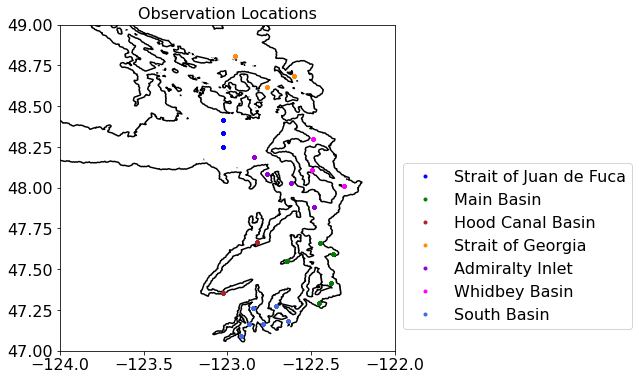

In [11]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
for ind, iregion in enumerate(data_CTD.Basin.unique()):
    ax.plot(datreg_CTD[iregion]['Lon'], datreg_CTD[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

# Absolute Salinity (g/kg)

### Table containing evaluation statistics for relevant subsets

In [12]:
# Setting Variable for Temperature. 
obsvar='SA'
modvar='mod_vosaline'
seasons=[JFM_CTD,Apr_CTD,MJJA_CTD,SOND_CTD]

In [13]:
statsDict_CTSA={year:dict()}
statsDict_CTSA[year]['SA']=OrderedDict()
for isub in statsubs_CTD:
    print(isub)
    statsDict_CTSA[year]['SA'][isub]=dict()
    var=statsDict_CTSA[year]['SA'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]],
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_CTSA[year]['SA'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, JFM
z < 15 m, Apr
z < 15 m, MJJA
z < 15 m, SOND
Strait of Juan de Fuca
Main Basin
Hood Canal Basin
Strait of Georgia
Admiralty Inlet
Whidbey Basin
South Basin


### Model vs Observed comparisons by depth and region

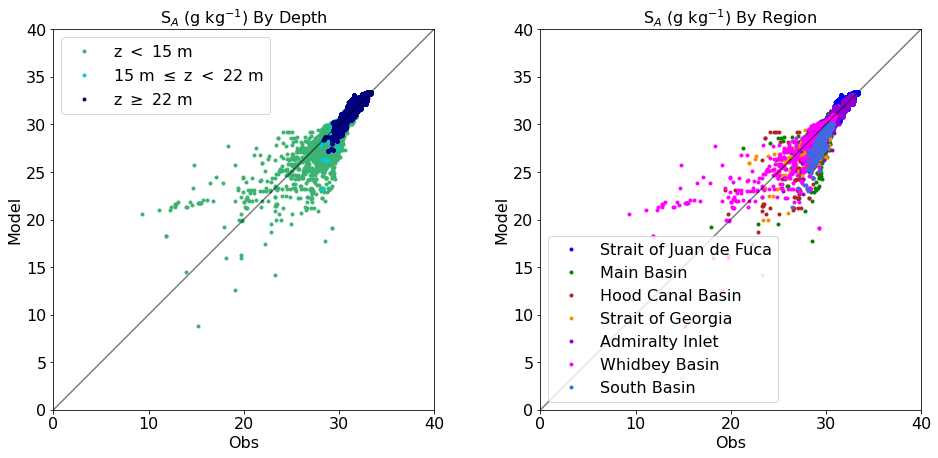

In [14]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data_CTD,ax[0],obsvar,modvar,(0,40))
ax[0].set_title('S$_A$ (g kg$^{-1}$) By Depth')

ps,l=byRegion(data_CTD,datreg_CTD,ax[1],obsvar,modvar,(0,40))
ax[1].set_title('S$_A$ (g kg$^{-1}$) By Region');

### A closer look at Salinity in South Basin

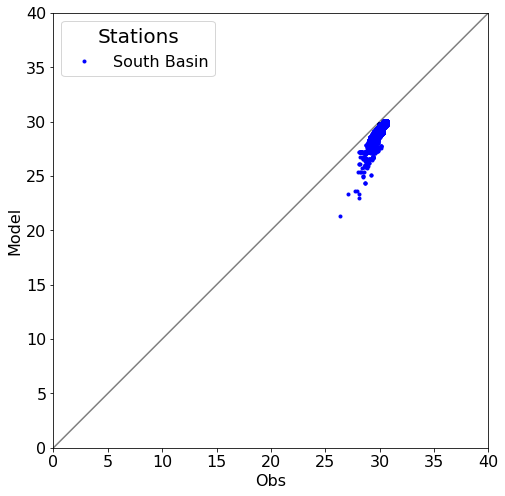

In [15]:
# Look at the salinity and divide up by depth. 
lims=(0,40)
ps=[]
fig, ax=plt.subplots(1,1,figsize=(12,8))
ax.plot(datreg_CTD['South Basin']['Lon'], datreg_CTD['South Basin']['Lat'],'.',
            color = colors[ind], label='South Basin')
ps0=et.varvarPlot(ax,datreg_CTD['South Basin'],obsvar,modvar,
             cols=(colors[0],),lname='South Basin')
ps.append(ps0)
l=ax.legend(title='Stations',title_fontsize=20,handles=[ip[0][0] for ip in ps])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.plot(lims,lims,'k-',alpha=.5)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect(1)

### 2D Histogram of model vs observed

Text(0.5, 1.0, 'S$_A$ (g kg$^{-1}$)')

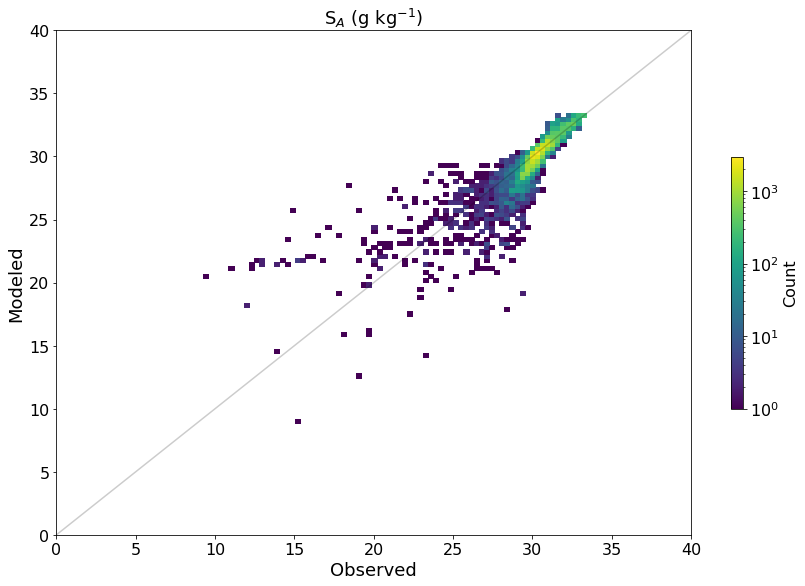

In [16]:
fig, ax = plt.subplots(1,1,figsize= (12,8))
ps = hist2d(data_CTD,ax,obsvar,modvar,(0,40),fontsize=18)
ax.set_title('S$_A$ (g kg$^{-1}$)',fontsize=18)

### Model vs observed comparisons for multiple seasons

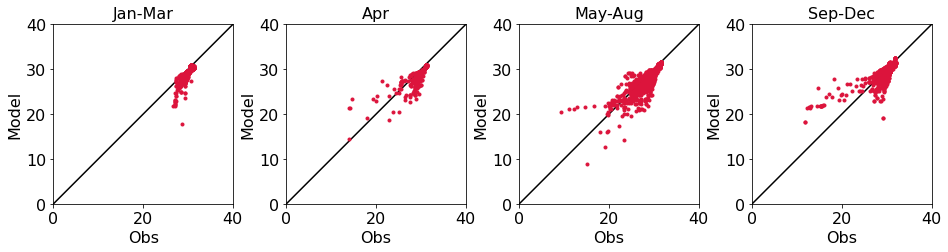

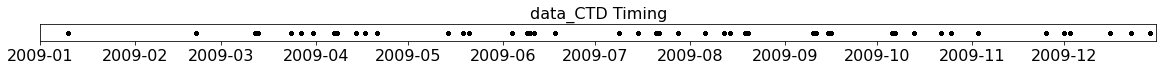

In [17]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(seasons,ax,obsvar,modvar,(0,40))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

# Conservative Temperature

In [18]:
#Setting variables for temperature.
obsvar='CT'
modvar='mod_votemper'
seasons=[JFM_CTD,Apr_CTD,MJJA_CTD,SOND_CTD]

### Table containing evaluation statistics for relevant subsets

In [21]:
statsDict_CTSA[year]['CT']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_CTSA[year]['CT'][isub]=dict()
    var=statsDict_CTSA[year]['CT'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]],
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_CTSA[year]['CT'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Model vs Observed comparisons by depth and region

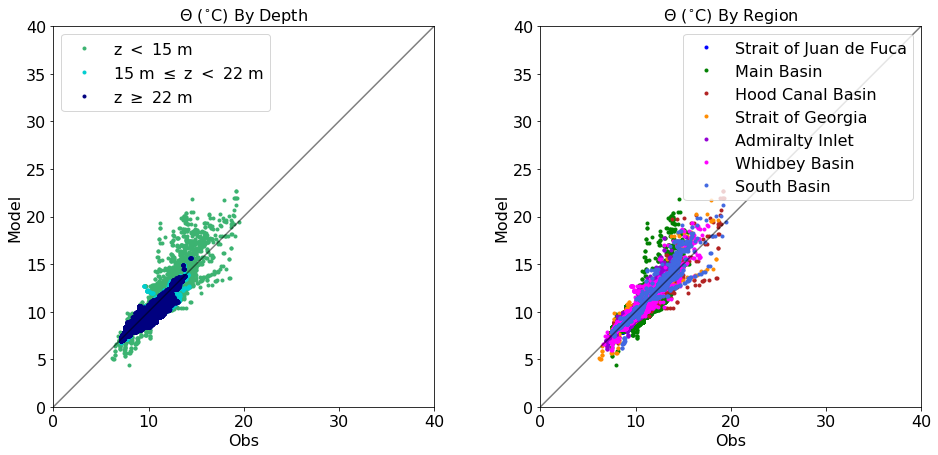

In [22]:
mv=(0,40)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data_CTD,ax[0],obsvar,modvar,mv)
ax[0].set_title('$\Theta$ ($^{\circ}$C) By Depth')

ps,l=byRegion(data_CTD,datreg_CTD,ax[1],obsvar,modvar,mv)
ax[1].set_title('$\Theta$ ($^{\circ}$C) By Region');

### 2D Histogram of model vs observed

Text(0.5, 1.0, '$\\Theta$ ($^{\\circ}$C)')

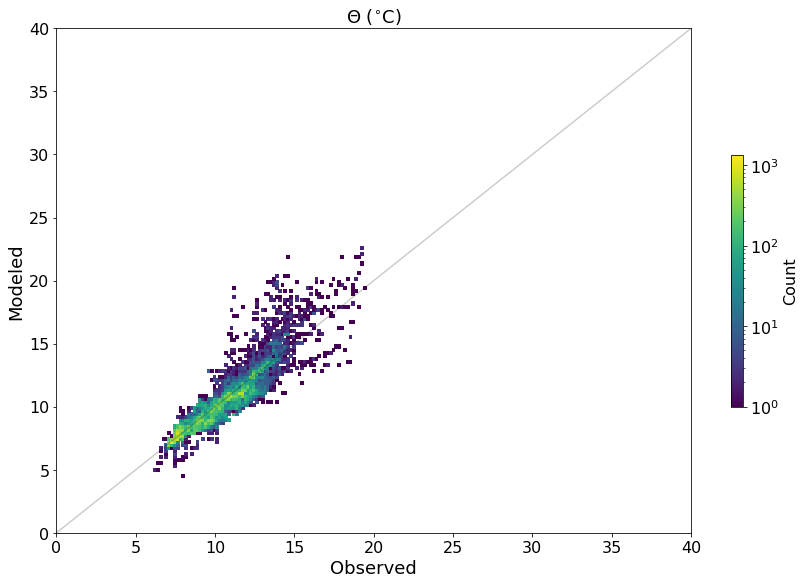

In [23]:
fig, ax = plt.subplots(1,1,figsize= (12,8))
ps = hist2d(data_CTD,ax,obsvar,modvar,(0,40),fontsize=18)
ax.set_title('$\Theta$ ($^{\circ}$C)',fontsize=18)

### Model vs observed comparisons for multiple seasons

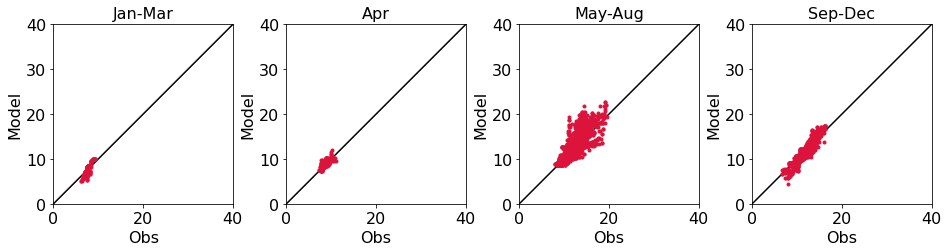

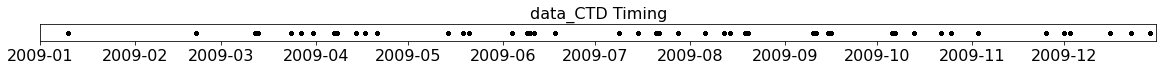

In [24]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(seasons,ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

### Temperature-Salinity by Region

In [25]:
def tsplot(ax,svar,tvar):
    limsS=(0,36)
    limsT=(5,20)
    ss,tt=np.meshgrid(np.linspace(limsS[0],limsS[1],20),np.linspace(limsT[0],limsT[1],20))
    rho=gsw.rho(ss,tt,np.zeros(np.shape(ss)))
    r=ax.contour(ss,tt,rho,colors='k')
    ps=list()
    for ind, iregion in enumerate(data_CTD.Basin.unique()):
        p=ax.plot(datreg_CTD[iregion][svar], datreg_CTD[iregion][tvar],'.',
                color = colors[ind], label=iregion)
        ps.append(p[0])
    l=ax.legend(handles=ps,bbox_to_anchor=(1.01,1))
    ax.set_ylim(limsT)
    ax.set_xlim(limsS)
    ax.set_ylabel('$\Theta$ ($^{\circ}$C)')
    ax.set_xlabel('S$_A$ (g kg$^{-1}$)')
    ax.set_aspect((limsS[1]-limsS[0])/(limsT[1]-limsT[0]))
    return

Text(0.5, 1.0, 'Modelled')

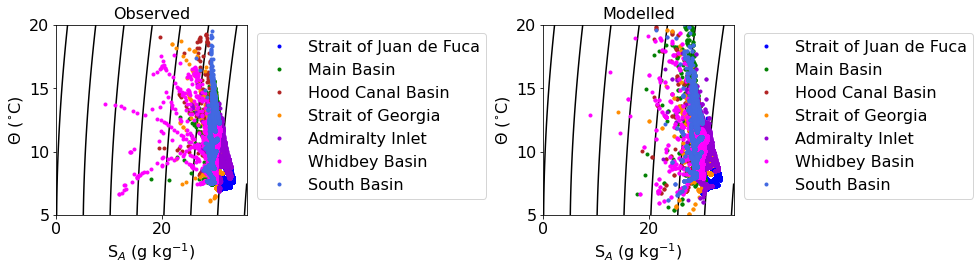

In [26]:
fig,ax=plt.subplots(1,2,figsize=(16,3.5))
tsplot(ax[0],'SA','CT')
ax[0].set_title('Observed')
tsplot(ax[1],'mod_vosaline','mod_votemper')
ax[1].set_title('Modelled')

### Summary table of temperature and salinity evaluation statistics

In [27]:
#No longer entirely accurate, should create seperate ones for each of the chlorophyll 
#comparisons and the CT SA analysis. Also should probably not log transform for the table.
tbl,tdf=et.displayStats(statsDict_CTSA[year],level='Variable',suborder=list(statsubs_CTD.keys()))
tbl

# Observed Chlorophyll vs Model Phytoplankton

In [47]:
#Setting variables for Chlorophyll.
obsvar='Chl'
modvar='mod_diatoms'
seasons=[JFM_CTD,Apr_CTD,MJJA_CTD,SOND_CTD]

## Model Diatoms vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets

In [48]:
statsDict_Chl={year:dict()}
statsDict_Chl[year]['Diatoms']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_Chl[year]['Diatoms'][isub]=dict()
    var=statsDict_Chl[year]['Diatoms'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]], 
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Diatoms'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Comparisons by depth and region

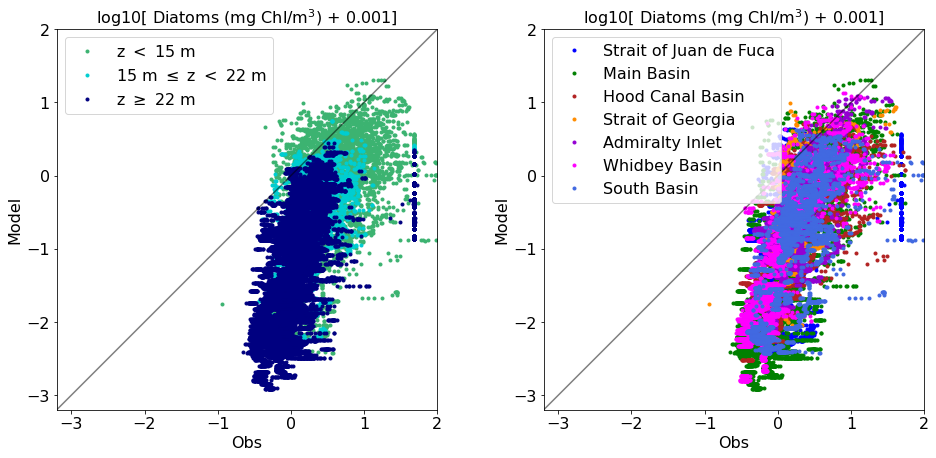

In [49]:
obsvar='log_Chl'
modvar='log_mod_diatoms'

mv=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data_CTD,ax[0],obsvar,modvar,mv)
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]')

ps,l=byRegion(data_CTD,datreg_CTD,ax[1],obsvar,modvar,mv)
ax[1].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]');

### 2D Histogram of model diatoms vs observed cholophyll

Text(0.5, 1.0, 'log10[ Diatoms (mg Chl/m$^3$) + 0.001]')

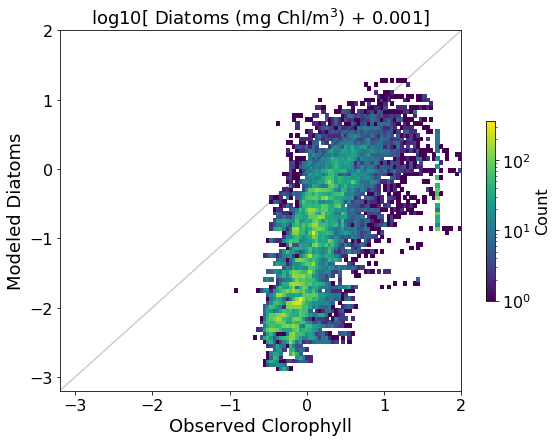

In [50]:
fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = hist2d(data_CTD,ax,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_ylabel('Modeled Diatoms')
ax.set_xlabel('Observed Clorophyll')              
ax.set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)

### Model vs observed comparisons for multiple seasons

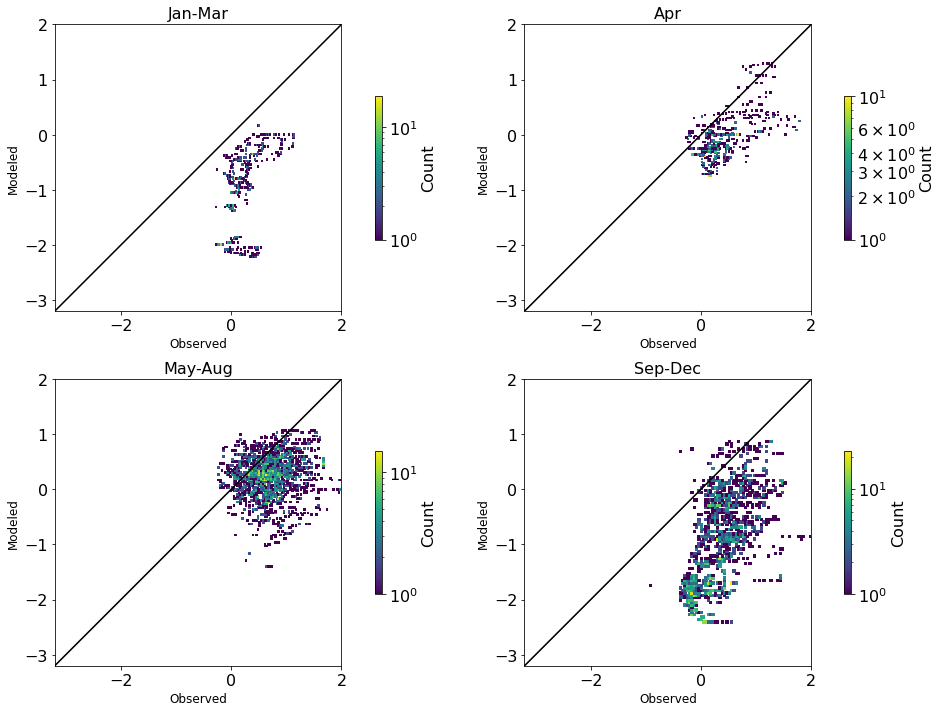

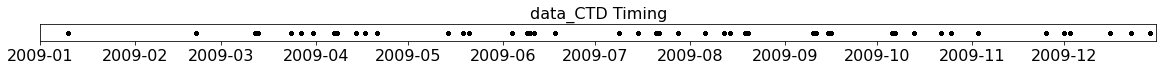

In [51]:
seasons=[JFM_CTD,Apr_CTD,MJJA_CTD,SOND_CTD]
fig, ax = plt.subplots(2,2,figsize = (16,10))
bySeason_hist2d(seasons,ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

## Model Ciliates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [52]:
obsvar='Chl'
modvar='mod_ciliates'

statsDict_Chl[year]['Ciliates']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_Chl[year]['Ciliates'][isub]=dict()
    var=statsDict_Chl[year]['Ciliates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]], 
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Ciliates'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Comparisons by depth and region

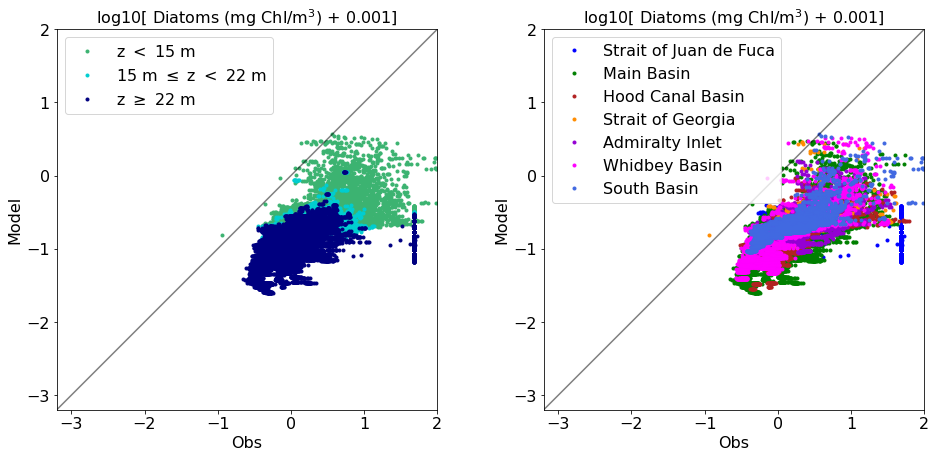

In [53]:
obsvar='log_Chl'
modvar='log_mod_ciliates'

mv=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data_CTD,ax[0],obsvar,modvar,mv)
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]')

ps,l=byRegion(data_CTD,datreg_CTD,ax[1],obsvar,modvar,mv)
ax[1].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]');

### 2D Histogram of model ciliates vs observed chlorophyll

Text(0.5, 1.0, 'log10[ Ciliates (mg Chl/m$^3$) + 0.001]')

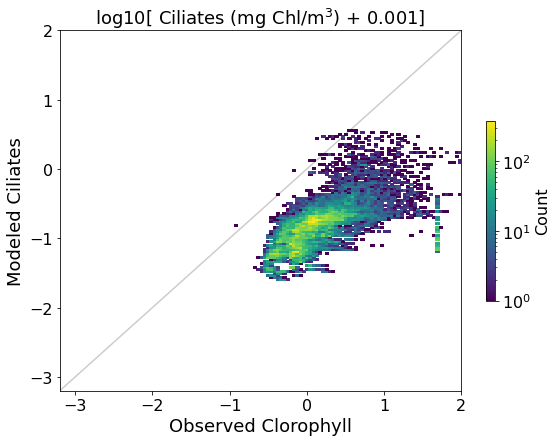

In [54]:
fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = hist2d(data_CTD,ax,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_ylabel('Modeled Ciliates')
ax.set_xlabel('Observed Clorophyll')              
ax.set_title('log10[ Ciliates (mg Chl/m$^3$) + 0.001]',fontsize=18)

## Model Ciliates vs observed Chlorophyll comparisons for multiple seasons

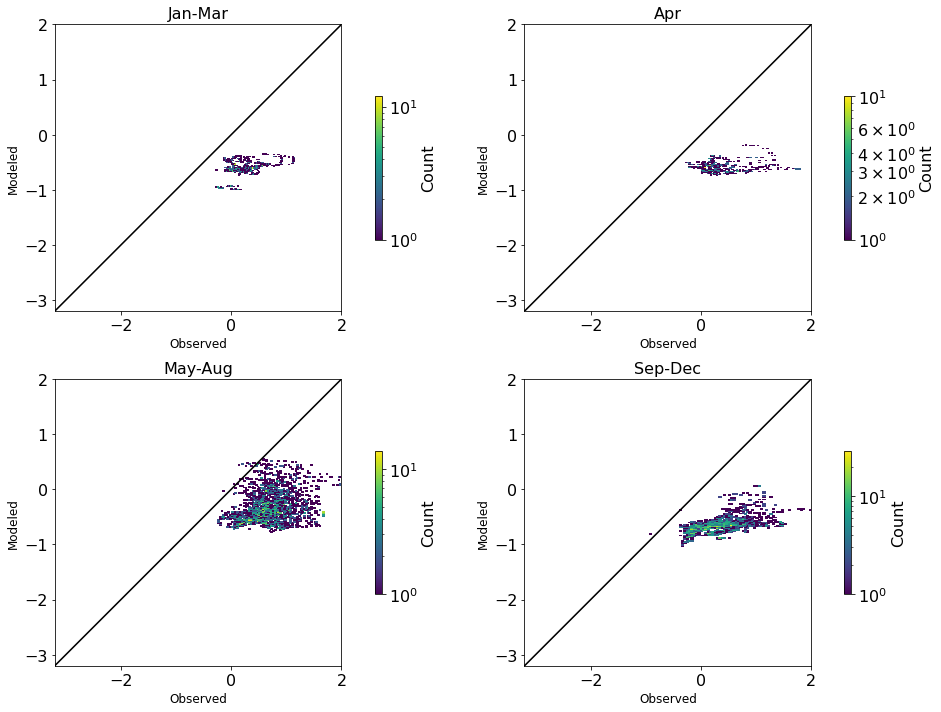

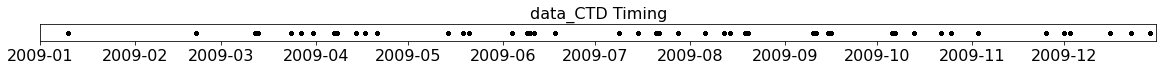

In [55]:
seasons=[JFM_CTD,Apr_CTD,MJJA_CTD,SOND_CTD]
fig, ax = plt.subplots(2,2,figsize = (16,10))
bySeason_hist2d(seasons,ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

## Model Flagellates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [56]:
obsvar='Chl'
modvar='mod_flagellates'

statsDict_Chl[year]['Flagellates']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_Chl[year]['Flagellates'][isub]=dict()
    var=statsDict_Chl[year]['Flagellates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]], 
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Flagellates'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Comparisons by depth and region

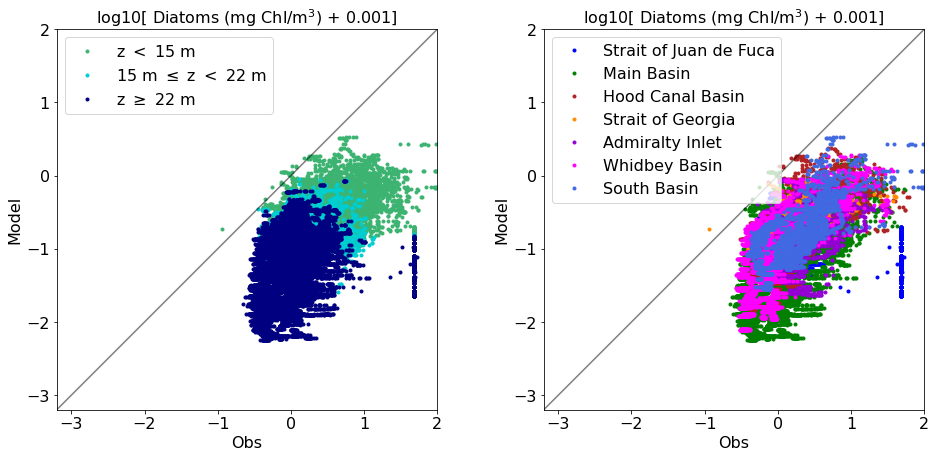

In [57]:
obsvar='log_Chl'
modvar='log_mod_flagellates'

mv=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data_CTD,ax[0],obsvar,modvar,mv)
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]')

ps,l=byRegion(data_CTD,datreg_CTD,ax[1],obsvar,modvar,mv)
ax[1].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]');

### 2D Histogram of model flagellates vs observed Chlorophyll

Text(0.5, 1.0, 'log10[ flagellates (mg Chl/m$^3$) + 0.001]')

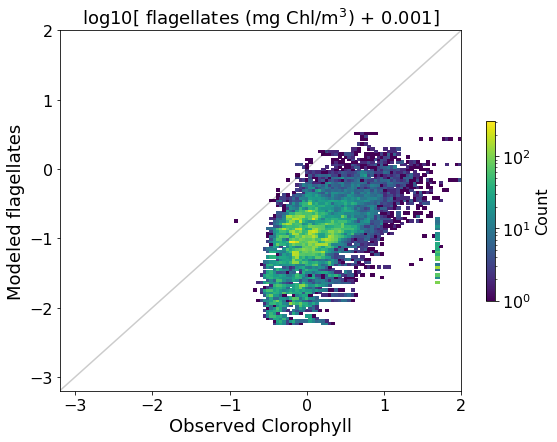

In [58]:
fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = hist2d(data_CTD,ax,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_ylabel('Modeled flagellates')
ax.set_xlabel('Observed Clorophyll')              
ax.set_title('log10[ flagellates (mg Chl/m$^3$) + 0.001]',fontsize=18)

### Model flagellates vs observed Chlorophyll comparisons for multiple seasons

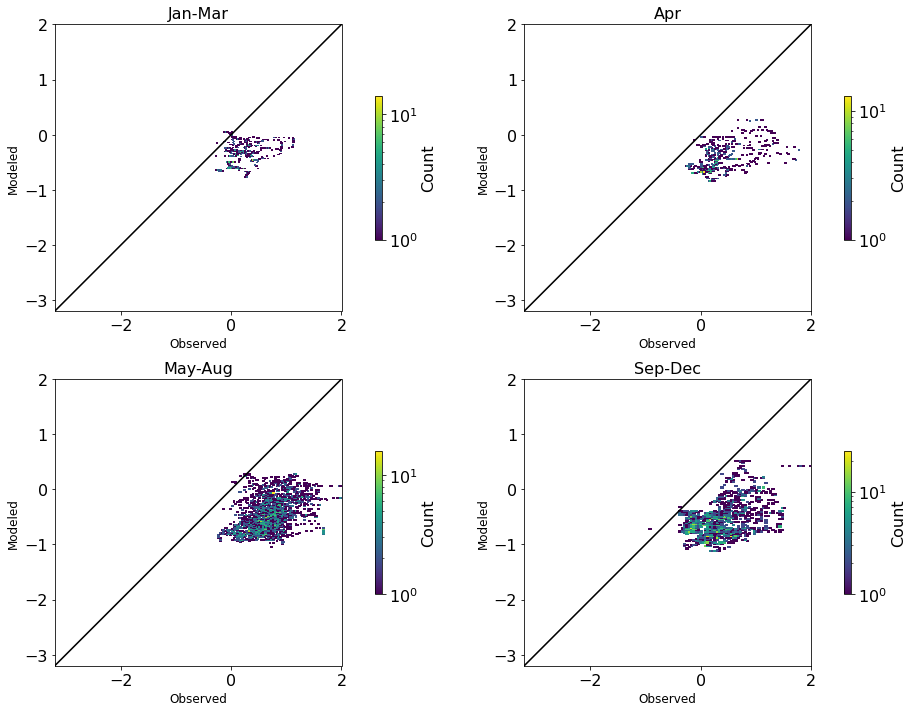

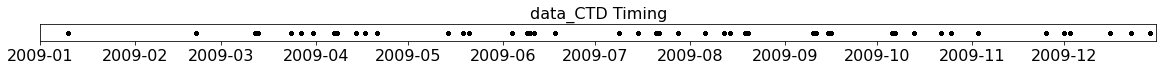

In [59]:
fig, ax = plt.subplots(2,2,figsize = (16,10))
bySeason_hist2d(seasons,ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

## All Model Phytoplankton vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [60]:
obsvar='Chl'
modvar='mod_Chl'

statsDict_Chl[year]['All']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_Chl[year]['All'][isub]=dict()
    var=statsDict_Chl[year]['All'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]], 
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['All'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Comparisons by depth and region

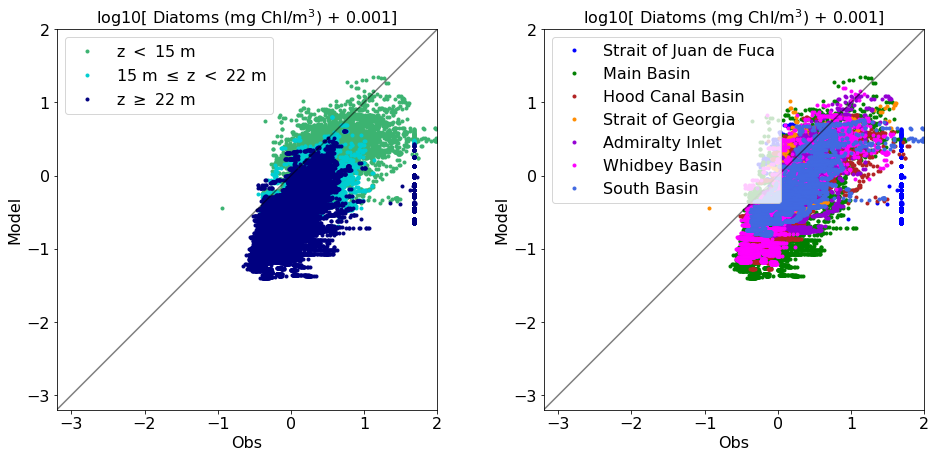

In [61]:
obsvar='log_Chl'
modvar='log_mod_Chl'

mv=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(data_CTD,ax[0],obsvar,modvar,mv)
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]')

ps,l=byRegion(data_CTD,datreg_CTD,ax[1],obsvar,modvar,mv)
ax[1].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]');

### 2D Histogram of all model phytoplankton vs observed Chlorophyll

In [62]:
def hist2d(data,ax,obsvar,modvar,lims,fontsize=12):
    ax.plot((-250,250),(-250,250),'k-',alpha=.2)
    ii=(~np.isnan(data[obsvar]))&(~np.isnan(data[modvar]))
    counts, xedges, yedges, ps=ax.hist2d(data.loc[ii,[obsvar]].values.flatten(),
                                      data.loc[ii,[modvar]].values.flatten(),bins=25*3,norm=LogNorm())
    cb=fig.colorbar(ps,ax=ax,label='Count',shrink=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_ylabel('Modeled',fontsize=fontsize)
    ax.set_xlabel('Observed',fontsize=fontsize)
    plt.tight_layout()
    return ps

def bySeason_hist2d(seaons,ax,obsvar,modvar,lims):
    for axj in ax:
        for axi in axj:
            axi.plot(lims,lims,'k-')
            axi.set_xlim(lims)
            axi.set_ylim(lims)
            axi.set_aspect(1)
            axi.set_xlabel('Obs')
            axi.set_ylabel('Model')
    jp=hist2d(seaons[0],ax[0][0],obsvar,modvar,lims)
    ax[0][0].set_title('Jan-Mar')
    jp=hist2d(seaons[1],ax[0][1],obsvar,modvar,lims)
    ax[0][1].set_title('Apr')
    jp=hist2d(seaons[2],ax[1][0],obsvar,modvar,lims)
    ax[1][0].set_title('May-Aug')
    jp=hist2d(seasons[3],ax[1][1],obsvar,modvar,lims)
    ax[1][1].set_title('Sep-Dec')
    return 

Text(0.5, 1.0, 'log10[ chlorophyll (mg Chl/m$^3$) + 0.001]')

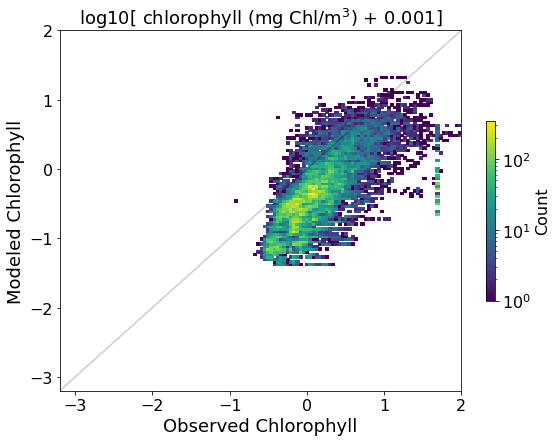

In [63]:
obsvar='log_Chl'
modvar='log_mod_Chl'

fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = hist2d(data_CTD,ax,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_ylabel('Modeled Chlorophyll')
ax.set_xlabel('Observed Chlorophyll')              
ax.set_title('log10[ chlorophyll (mg Chl/m$^3$) + 0.001]',fontsize=18)

## Model Chlorophyll vs observed Chlorophyll comparisons for multiple seasons

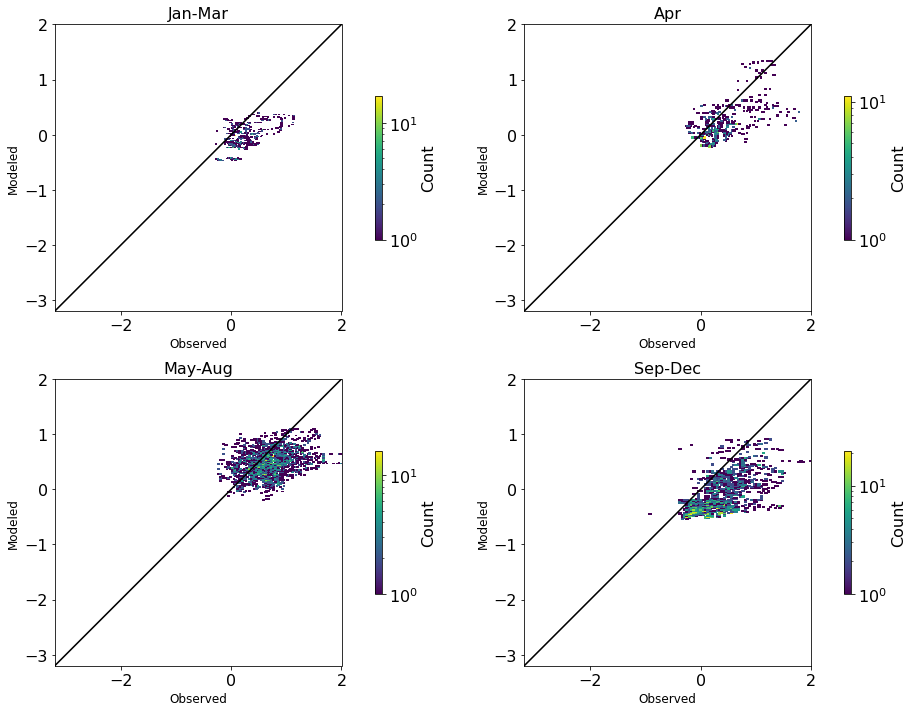

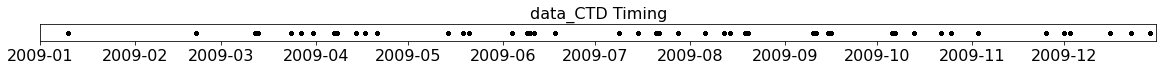

In [64]:
seasons=[JFM_CTD,Apr_CTD,MJJA_CTD,SOND_CTD]
fig, ax = plt.subplots(2,2,figsize = (16,10))
bySeason_hist2d(seasons,ax,obsvar,modvar,(-3.2,2))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

### Summary table of evaluation statistics for Temperature, Salinity, and Chlorophyll.

In [65]:
#No longer entirely accurate, should create seperate ones for each of the chlorophyll 
#comparisons and the CT SA analysis. Also should probably not log transform for the table.
tbl,tdf=et.displayStats(statsDict_Chl[year],level='Variable',suborder=list(statsubs_CTD.keys()))
tbl